# Setup

# This notebook contains:
-The deep learning model experimentation

-How I experiment with the BERT embedding

-Parameter optimisation for the BERT embedding

-Evaluation on the test data


In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.17.0
    Uninstalling tf_keras-

In [ ]:
!pip install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 6.0 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=c2495ead6862fbe677362bab893ddf4c3c20cf41e84bdc43c22cc49de29e857d
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import math
import json


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
from official.nlp import optimization


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

tf.get_logger().setLevel('ERROR')

In [ ]:
# load the preprocessed data from my google drive
#newsdata = pd.read_csv('/content/drive/MyDrive/experiment_1_preprocessed.csv')

newsdata = pd.read_csv('/content/drive/MyDrive/intermediary.csv')

# drop remaining empty rows in the titles series
newsdata.dropna(inplace=True)

data = newsdata.copy()


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
# Make a model
classifier_model2 = build_classifier_model()

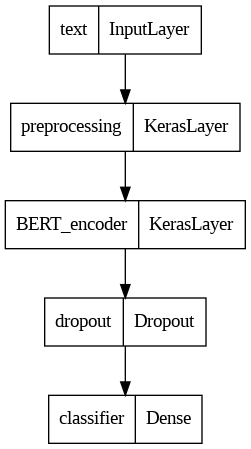

In [ ]:
# plot model architecture
tf.keras.utils.plot_model(classifier_model2)

In [ ]:
# split training and test data
# grab all columns needed for the final models.
x_train, x_test, y_train, y_test = train_test_split(data[['title_processed', 'title_no_lemma', 'text_processed', 'text_no_lemma', 'title_text_no_lemma', 'title_text_lemma']], data.target, test_size=0.3, random_state=4578)

# sub set training data for validation
x_val2 = x_train[-10000:]
y_val2 = y_train[-10000:]

x_train2 = x_train[:-10000]
y_train2 = y_train[:-10000]

In [ ]:
# set the loss function and the metric for the first model
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 5
steps_per_epoch = 512
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# instantiate a model
classifier_model2.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:

# train model a with training and validation included in one

history_2 = classifier_model2.fit(x=x_train2.title_processed,y=y_train2,
                               validation_data=(x_val2.title_processed, y_val2),
                               epochs=epochs)

Epoch 1/5
809/809 [==============================] - 577s 704ms/step - loss: 0.4360 - binary_accuracy: 0.7741 - val_loss: 0.3052 - val_binary_accuracy: 0.8667
Epoch 2/5
809/809 [==============================] - 556s 686ms/step - loss: 0.2967 - binary_accuracy: 0.8727 - val_loss: 0.2775 - val_binary_accuracy: 0.8830
Epoch 3/5
809/809 [==============================] - 559s 691ms/step - loss: 0.2697 - binary_accuracy: 0.8863 - val_loss: 0.2700 - val_binary_accuracy: 0.8877
Epoch 4/5
809/809 [==============================] - 557s 689ms/step - loss: 0.2655 - binary_accuracy: 0.8870 - val_loss: 0.2698 - val_binary_accuracy: 0.8876
Epoch 5/5
809/809 [==============================] - 557s 689ms/step - loss: 0.2610 - binary_accuracy: 0.8907 - val_loss: 0.2698 - val_binary_accuracy: 0.8876


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


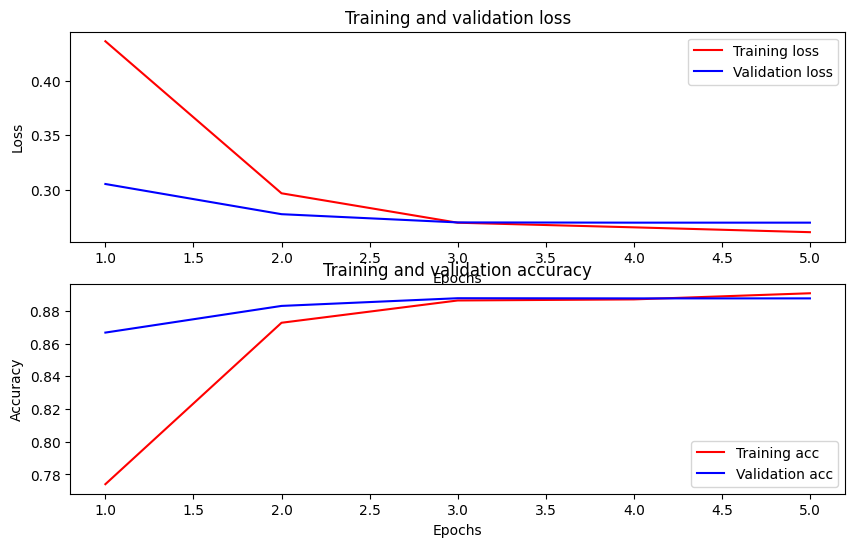

In [ ]:
history_dict = history_2.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')

plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:

# save model for later
dataset_name = 'news_titles_fully_trained'
save_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model2.save(save_model_path, include_optimizer=False)

In [ ]:
# custom optimiser function
def makeOptimiser(epochs: int, x_train_shape: int, batch_size: int, init_lr, optimizer_type='adamw' ):

  # Calculate the steps per epoch, this is dependent on batch size
  steps_per_epoch = int(math.ceil(x_train_shape / batch_size))

  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = int(0.1*num_train_steps)

  # return the optimiser
  return optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type=optimizer_type)




In [ ]:

# instantiate a temporary model
def instantiateModel(epochs: int, batch_size: int, modelname:str, init_lr, train_x, train_y, val_x, val_y):

  # Call the method to build the classifier
  tmp_model = build_classifier_model()

  # Set accuracy as the validation metric
  metrics = tf.metrics.BinaryAccuracy()

  # Call the custom optimiser method
  # with the variable number of epochs, learniing rate
  optimizer = makeOptimiser(epochs=epochs, x_train_shape=train_x.shape[0], batch_size=batch_size, init_lr=init_lr, optimizer_type='adamw')

  # Compile the model.
  tmp_model.compile(optimizer=optimizer,loss=loss, metrics=metrics)

  print('Training a model with params', str(epochs), str(init_lr))
  tmp_history = tmp_model.fit(x=train_x,y=train_y,
                               validation_data=(val_x, val_y),
                               epochs=epochs)

  # path to where the model is saved
  dataset_name = '{}{}{}'.format(epochs, modelname, init_lr)
  save_model_path = 'drive/MyDrive/{}_bert'.format(dataset_name.replace('/', '_'))

  # Save the model
  tmp_model.save(save_model_path, include_optimizer=False)

  # Return the dictionary of results
  return tmp_history.history

In [ ]:
# already tried: 5 epochs and 3e-5 lr as well as 512 training steps
# try different epochs: 3,4
# try different init_lr: 2e-5, 3e-5, 5e-5
# try different steps per epoch int(math.ceil(x_train.shape[0] / batch_size)), int(math.ceil(x_train.shape[0] / batch_size)) /2

epochs = [3, 4, 5]
init_lrs = [2e-5, 3e-5, 5e-5]
batch_size = 32
results = []
for epoch in epochs:
  for lr in init_lrs:
    results.append(instantiateModel(epochs=epoch, batch_size=batch_size, init_lr=lr, modelname='trainmodel', train_x=x_train2.title_processed, train_y=y_train2, val_x=x_val2.title_processed, val_y=y_val2))
    filename = 'drive/MyDrive/{}mydata{}'.format(epoch, lr)
    with open(filename, "w") as intermediary_data:
      json.dump(results, intermediary_data)


Training a model with params 3 2e-05
Epoch 1/3
666/666 [==============================] - 455s 677ms/step - loss: 0.5614 - binary_accuracy: 0.6647 - val_loss: 0.3720 - val_binary_accuracy: 0.8461
Epoch 2/3
666/666 [==============================] - 446s 670ms/step - loss: 0.3716 - binary_accuracy: 0.8350 - val_loss: 0.3316 - val_binary_accuracy: 0.8638
Epoch 3/3
666/666 [==============================] - 438s 658ms/step - loss: 0.3332 - binary_accuracy: 0.8545 - val_loss: 0.3134 - val_binary_accuracy: 0.8675
Training a model with params 3 3e-05
Epoch 1/3
666/666 [==============================] - 406s 603ms/step - loss: 0.4961 - binary_accuracy: 0.7378 - val_loss: 0.3565 - val_binary_accuracy: 0.8522
Epoch 2/3
666/666 [==============================] - 437s 656ms/step - loss: 0.3344 - binary_accuracy: 0.8526 - val_loss: 0.3146 - val_binary_accuracy: 0.8702
Epoch 3/3
666/666 [==============================] - 398s 598ms/step - loss: 0.2971 - binary_accuracy: 0.8725 - val_loss: 0.2958 - 

In [ ]:
f = open('drive/MyDrive/testing_results_dl.json')
results = json.load(f)
results = json.loads(results)
results = pd.DataFrame(results)

results = results.map(np.mean)


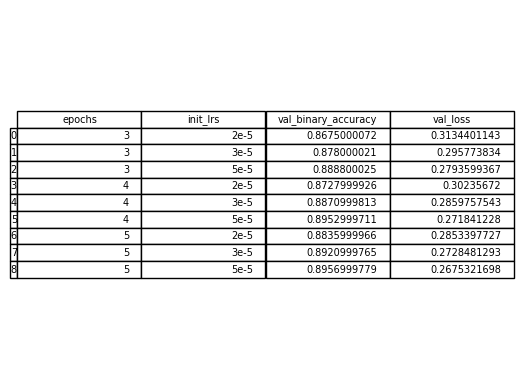

In [ ]:

results['epochs'] = 3
results.loc['3':'5','epochs'] =4
results.loc['6':'8','epochs'] =5
results['init_lrs'] = '2e-5'
results.loc[['1','4','7'], 'init_lrs'] = '3e-5'
results.loc[['2','5','8'], 'init_lrs'] = '5e-5'
results['val_binary_accuracy'] = results['val_binary_accuracy'].apply(lambda x: x[-1])
results['val_loss'] = results['val_loss'].apply(lambda x: x[-1])

ax = plt.subplot(111, frame_on=False)  # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
table(ax, results.iloc[:,[4,5,3,2]], loc="center")  # results is the data
plt.savefig("drive/MyDrive/DL_table_validation_results.png")

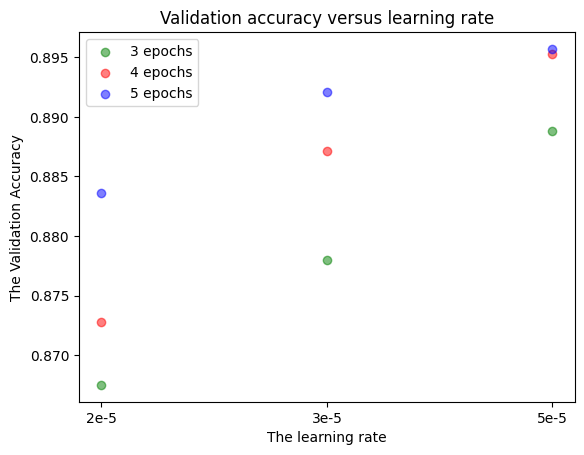

In [ ]:

x_3epochs = results.iloc[:3,3:]['init_lrs']
y_3epochs = results.iloc[:3,3:]['val_binary_accuracy']
plt.scatter(x_3epochs, y_3epochs, color='green',alpha=0.5, label='3 epochs')

x_4epochs = results.iloc[3:6,3:]['init_lrs']
y_4epochs = results.iloc[3:6,3:]['val_binary_accuracy']
plt.scatter(x_4epochs, y_4epochs, color='red', alpha=0.5, label='4 epochs')

x_5epochs = results.iloc[6:,3:]['init_lrs']
y_5epochs = results.iloc[6:,3:]['val_binary_accuracy']
plt.scatter(x_5epochs, y_5epochs, color='blue', alpha=0.5, label='5 epochs')


plt.title('Validation accuracy versus learning rate')
plt.xlabel('The learning rate')
plt.ylabel('The Validation Accuracy')
plt.legend()

plt.savefig('drive/MyDrive/accuracy_lr.png')

In [ ]:
# train non lemmatised title
instantiateModel(epochs=5, batch_size=32, init_lr=5e-5, modelname='title_no_lemma', train_x=x_train2.title_no_lemma, train_y=y_train2, val_x=x_val2.title_no_lemma, val_y=y_val2)

# train title text with lemma
instantiateModel(epochs=5, batch_size=32, init_lr=5e-5, modelname='title_text_lemma', train_x=x_train2.title_text_lemma, train_y=y_train2, val_x=x_val2.title_text_lemma, val_y=y_val2)

# train title text with no lemma
instantiateModel(epochs=5, batch_size=32, init_lr=5e-5, modelname='title_text_no_lemma', train_x=x_train2.title_text_no_lemma, train_y=y_train2, val_x=x_val2.title_text_no_lemma, val_y=y_val2)

# train full text lemmatised
instantiateModel(epochs=5, batch_size=32, init_lr=5e-5, modelname='full_text_lemma', train_x=x_train2.text_processed, train_y=y_train2, val_x=x_val2.text_processed, val_y=y_val2)

# Train full text model no lemma
instantiateModel(epochs=5, batch_size=32, init_lr=5e-5, modelname='full_text_no_lemma', train_x=x_train2.text_no_lemma, train_y=y_train2, val_x=x_val2.text_no_lemma, val_y=y_val2)


Training a model with params 5 5e-05
Epoch 1/5
666/666 [==============================] - 532s 791ms/step - loss: 0.4170 - binary_accuracy: 0.7952 - val_loss: 0.2734 - val_binary_accuracy: 0.8899
Epoch 2/5
666/666 [==============================] - 489s 735ms/step - loss: 0.2550 - binary_accuracy: 0.8945 - val_loss: 0.2528 - val_binary_accuracy: 0.8891
Epoch 3/5
666/666 [==============================] - 403s 605ms/step - loss: 0.2192 - binary_accuracy: 0.9112 - val_loss: 0.2375 - val_binary_accuracy: 0.8993
Epoch 4/5
666/666 [==============================] - 442s 664ms/step - loss: 0.1962 - binary_accuracy: 0.9188 - val_loss: 0.2387 - val_binary_accuracy: 0.9005
Epoch 5/5
666/666 [==============================] - 476s 715ms/step - loss: 0.1859 - binary_accuracy: 0.9247 - val_loss: 0.2341 - val_binary_accuracy: 0.9031


{'loss': [0.4170490801334381,
  0.25501811504364014,
  0.21924403309822083,
  0.19619280099868774,
  0.18587107956409454],
 'binary_accuracy': [0.7951524257659912,
  0.8945465087890625,
  0.9112217426300049,
  0.9187843203544617,
  0.9247498512268066],
 'val_loss': [0.27344605326652527,
  0.25276845693588257,
  0.2374613732099533,
  0.23865938186645508,
  0.23410268127918243],
 'val_binary_accuracy': [0.8899000287055969,
  0.8891000151634216,
  0.8992999792098999,
  0.9004999995231628,
  0.9031000137329102]}

In [ ]:
def scoreModel(modelname: str, test_x, test_y) -> dict:

  # load the model
  loaded_model = tf.saved_model.load(modelname)

  # get predictions
  y_predictions = tf.sigmoid(loaded_model(tf.constant(test_x)))

  y_predictions = y_predictions.numpy().flatten()

  # convert to classes
  y_classes = ((y_predictions > 0.5)+0).ravel()

  # get fpr and tpr for roc_curve, then calculate roc_auc
  fpr, tpr, thresholds = roc_curve(y_test, y_predictions)
  roc_auc = auc(fpr, tpr)

  # calculate accuracy
  acc = accuracy_score(test_y, y_classes)

  # calculate f1
  f1 = f1_score(test_y, y_classes)

  return {'Accuracy': acc, 'F1': f1, 'ROC_AUC': roc_auc}



In [ ]:
# dictionary to store the results of the tested models in
dl_results = {}

# path to the models trained on the article titles
title_lemma = 'drive/MyDrive/classifying_fake_real_news/models/title_lemma/5modelname5e-05_bert'
title_no_lemma = 'drive/MyDrive/classifying_fake_real_news/models/5title_no_lemma5e-05_bert'

# path to the models trained on the article titles and first 200 words of the text
title_text_lemma = 'drive/MyDrive/classifying_fake_real_news/models/5title_text_lemma5e-05_bert'
title_text_no_lemma = 'drive/MyDrive/classifying_fake_real_news/models/5title_text_no_lemma5e-05_bert'

# path to the models trained on the full article texts
full_text_lemma = 'drive/MyDrive/classifying_fake_real_news/models/5full_text_lemma5e-05_bert'
full_text_no_lemma = 'drive/MyDrive/classifying_fake_real_news/models/5full_text_no_lemma5e-05_bert'

# test the lemmatised and unlemmatised titles
dl_results['Title Lemmatised'] = scoreModel(modelname=title_lemma, test_x=x_test.title_processed, test_y=y_test)
dl_results['Title No Lemma'] = scoreModel(modelname=title_no_lemma, test_x=x_test.title_no_lemma, test_y=y_test)

# test the lemmatised and unlemmatised titles and first 200 words of the text
dl_results['Title Text Lemmatised'] = scoreModel(modelname=title_text_lemma, test_x=x_test.title_text_lemma, test_y=y_test)
dl_results['Title Text No Lemma'] = scoreModel(modelname=title_text_no_lemma, test_x=x_test.title_text_no_lemma, test_y=y_test)

# test the lemmatised and unlemmatised full text models
dl_results['Full Text Lemmatised'] = scoreModel(modelname=full_text_lemma, test_x=x_test.text_processed, test_y=y_test)
dl_results['Full Text No Lemma'] = scoreModel(modelname=full_text_no_lemma, test_x=x_test.text_no_lemma, test_y=y_test)


,Accuracy,F1,ROC_AUC
Title Lemmatised,0.900746,0.910701,0.964304
Title No Lemma,0.915735,0.922411,0.972819
Title Text Lemmatised,0.962640,0.965621,0.992817
Title Text No Lemma,0.963684,0.966582,0.992681
Full Text Lemmatised,0.955332,0.959015,0.990115
Full Text No Lemma,0.955928,0.959501,0.989498


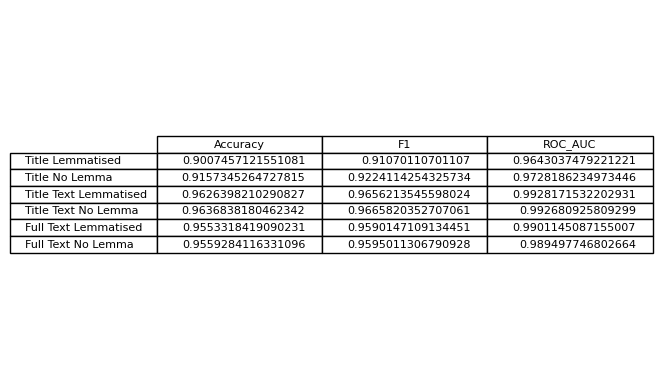

In [ ]:
# store the dataframe of the testing result in a png file
ax = plt.subplot(111, frame_on=False)  # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
table(ax, pd.DataFrame.from_dict(dl_results, orient='index'), loc="center")
plt.savefig("drive/MyDrive/DL_table_test_results.png")

# show the DataFrame of the result of the dl models
pd.DataFrame.from_dict(dl_results, orient='index')